In [1]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

In [2]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load('ViT-B/32', device)

cuda


In [3]:
from PIL import Image
import os
import numpy as np

# this is the folder name of the dataset
# dataset_path = "C:/Users/arist/Desktop/Thesis/Sketch-Icon-Retrieval/Sketch-Icon-Dataset/"
# dataset_path = "C:/Users/arist/Desktop/Code-Quickdraw-Dataset/"
dataset_path = "C:/Users/arist/Desktop/Code-Human-Dataset/"
# this is the folder name of the icons
icon_path = os.path.join(dataset_path, 'icon/')
# this is the folder name of the sketches
sketch_path = os.path.join(dataset_path, 'sketch/')

input_shape = (224, 224)

def load_img(path):
    """
    path: the full path of the picture
    Load the image using cv2, store the pixels devided by 255
    into img and resize the image to (100,100). This input size is the 
    size for mynet model
    """
    img = Image.open(path)#/255
    return img.resize(input_shape)

def load_test_set():
    """
    Load a numpy array created by GenerateTrainAndTestSet.ipynb file
    The array has 2 columns (name, category) and each row is a test sketch example
    This arrays are created, so the classification training and the triplet training will have the same
    training and test examples. I use 10% of the sketches as test examples.
    """
    return np.load(dataset_path + "test_set_human.npy")

def get_icons_and_sketches():
    """[summary]
    icon_name: list of the icon names in all the category folders
    icon_category: list of the icon categories. this list is parallel with icon_name
    as a result for each icon I store its category
    sketch_name: list of the sketch names in all the category folders
    sketch_category: list of the sketch categories. this list is parallel with sketch_name
    as a result for each sketch I store its category

    Returns:
    icon_name_category: np array with two columns (icon name, icon category)
    sketch_name_category: np array with two columns (sketch name, sketch category)
    """
    icon_name = []
    icon_category = []
    sketch_name = []
    sketch_category = []

    for category in os.listdir(icon_path):
        category_path_icon = os.path.join(icon_path, category)
        for icon in os.listdir(category_path_icon):
            icon_name.append(icon.replace(".jpg",""))
            icon_category.append(category)
    for category in os.listdir(sketch_path):
        category_path_sketch = os.path.join(sketch_path, category)
        for sketch in os.listdir(category_path_sketch):
            sketch_name.append(sketch)
            sketch_category.append(category)
    
    icon_name_category =  np.column_stack((icon_name, icon_category))
    sketch_name_category =  np.column_stack((sketch_name, sketch_category))
    
    return icon_name_category, sketch_name_category

def get_batch_sketches(batch_sketches):
    """[summary]

    Args:
        batch_sketches np.array(sketch name, sketch category): numpy array of sketch names and categories as columns

    Returns:
        sketches tensor(BATCH_SIZE, 3, 224, 224): batch of sketches as pixels
    """
    s_ = []
    for sketch, category in batch_sketches:
        sketch_path_file = sketch_path + category + "/" + sketch
        s_.append(sketch_path_file)
    sketch_list = []
    for image_path in s_:
        image = load_img(image_path)
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        sketch_list.append(image_tensor)

    return torch.cat([x.float() for x in sketch_list], dim=0)

def get_batch_icons(batch_icons):
    """[summary]

    Args:
        batch_icons np.array(icon name, icon category): numpy array of icon names and categories as columns

    Returns:
        icons tensor(BATCH_SIZE, 3, 224, 224): batch of icons as pixels
    """
    i_ = []
    for icon, category in batch_icons:
        icon_path_file = icon_path + category + "/" + icon + ".jpg"
        i_.append(icon_path_file)

    icon_list = []
    for image_path in i_:
        image = load_img(image_path)
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        icon_list.append(image_tensor)

    return torch.cat([x.float() for x in icon_list], dim=0)

icon_name_category, sketch_name_category = get_icons_and_sketches()
print(sketch_name_category)

[['accessible-icon_1.png' 'accessibility']
 ['accessible-icon_10.png' 'accessibility']
 ['accessible-icon_11.png' 'accessibility']
 ...
 ['sticky-note_7.png' 'writing']
 ['sticky-note_8.png' 'writing']
 ['sticky-note_9.png' 'writing']]


In [4]:
options = 1
if options == 0:
    sketches_Test = sketch_name_category
    icons_Test = icon_name_category
elif options == 1:
    sketches_Test = load_test_set()
    icons_Test = icon_name_category

In [62]:
text_inputs = torch.cat([clip.tokenize(f"a sketch of a {c}") for c,_ in icons_Test]).to(device)
# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)

In [5]:
sketch_features_list = []
BATCH_SIZE = 1024
for j in range(0, len(sketches_Test), BATCH_SIZE):
    batch_sketches = sketches_Test[j:j+BATCH_SIZE]
    sketch_array = get_batch_sketches(batch_sketches)
    with torch.no_grad():
        sketch_features = model.encode_image(sketch_array)
    sketch_features_list.append(sketch_features)
    print(str(j))
sketch_features_tensor = torch.cat([x.float() for x in sketch_features_list], dim=0)

0


In [64]:
text_features = text_features.float()
acc_1 = 0
acc_10 = 0

for sketch_features, (name,_) in zip(sketch_features_tensor, sketches_Test):
    # Pick the top 5 most similar labels for the image
    sketch_features = sketch_features.unsqueeze(0)
    sketch_features /= sketch_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (100.0 * sketch_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(10)
    top_10 = 0
    count = 0
    for index in indices:
        if icons_Test[index][0] == name.split("_")[0] and count == 0:
            acc_1 = acc_1 + 1
            acc_10 = acc_10 + 1
            break
        elif icons_Test[index][0] == name.split("_")[0]:
            acc_10 = acc_10 + 1
            break
        count = count + 1

print("Top 1: " + str(acc_1/len(sketches_Test)))
print("Top 10: " + str(acc_10/len(sketches_Test)))   

Top 1: 0.09622641509433963
Top 10: 0.269811320754717


In [6]:
icon_features_list = []
BATCH_SIZE = 1024
for j in range(0, len(icons_Test), BATCH_SIZE):
    batch_icons = icons_Test[j:j+BATCH_SIZE]
    icon_array = get_batch_icons(batch_icons)
    with torch.no_grad():
        icon_features = model.encode_image(icon_array)
    icon_features_list.append(icon_features)
    print(str(j))
icon_features_tensor = torch.cat([x.float() for x in icon_features_list], dim=0)

0
1024


## Sketch-Icon Retrieval tested with cosine similarity

Top 1: 0.2043956043956044
Top 10: 0.4967032967032967


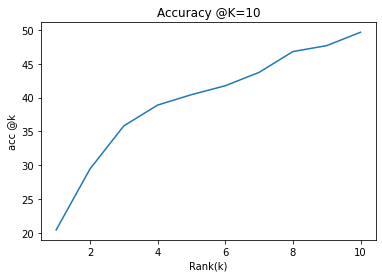

In [9]:
acc_1 = 0
acc_10 = 0
top_k_list = [0] * 10
for sketch_features, (name,_) in zip(sketch_features_tensor, sketches_Test):
    # Pick the top 10 most similar labels for the image
    sketch_features = sketch_features.unsqueeze(0)
    sketch_features /= sketch_features.norm(dim=-1, keepdim=True)
    icon_features_tensor /= icon_features_tensor.norm(dim=-1, keepdim=True)

    similarity = (100.0 * sketch_features @ icon_features_tensor.T).softmax(dim=-1)
    values, indices = similarity[0].topk(10)
    top_10 = 0
    count = 0
    for index in indices:
        if icons_Test[index][0] == name.split("_")[0] and count == 0:
            top_k_list[count] = top_k_list[count] + 1
            acc_1 = acc_1 + 1
            acc_10 = acc_10 + 1
            break
        elif icons_Test[index][0] == name.split("_")[0]:
            top_k_list[count] = top_k_list[count] + 1
            acc_10 = acc_10 + 1
            break
        count = count + 1

print("Top 1: " + str(acc_1/len(sketches_Test)))
print("Top 10: " + str(acc_10/len(sketches_Test)))

axisX = [0] * 10
for i in range(0 , len(axisX)):
  axisX[i] = i + 1

for i in range(1, len(top_k_list)):
  top_k_list[i] = top_k_list[i] + top_k_list[i-1]
  top_k_list[i-1] = top_k_list[i-1] / len(sketches_Test) * 100
top_k_list[9] = top_k_list[9] / len(sketches_Test) * 100

plt.plot(axisX,top_k_list)
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)
plt.title('Accuracy @K=10')
plt.xlabel('Rank(k)')
plt.ylabel('acc @k')
plt.show()

In [53]:
folder_path = "C:\\Users\\arist\\Desktop\\Results-Cluster\\ResNet50\\CLIP-Pretrained ResNet-Original\\Code-Human-Dataset\\"
rank_file = open(folder_path + "top_10.txt","w+")
top_10_list_string = ['{:.2f}'.format(x) for x in top_k_list]
for value in top_10_list_string:
  rank_file.write(value + "\n")
rank_file.close()

## Sketch-Icon Retrieval tested with Euclidean distance

In [13]:
acc_1 = 0
acc_10 = 0
sketch_features_numpy = sketch_features_tensor.cpu().numpy()
icon_features_numpy = icon_features_tensor.cpu().numpy()
for sketch_features, (name,_) in zip(sketch_features_numpy, sketches_Test):
    # Pick the top 5 most similar labels for the image
    sketch_representations_tile = np.tile(sketch_features, len(icons_Test)).reshape(len(icons_Test), 512)
    diff = np.sqrt(np.mean((sketch_representations_tile - icon_features_numpy)**2, -1))
    top_k = np.argsort(diff)[:10]
    top_10 = 0
    count = 0
    for index in top_k:
        if icons_Test[index][0] == name.split("_")[0] and count == 0:
            acc_1 = acc_1 + 1
            acc_10 = acc_10 + 1
            break
        elif icons_Test[index][0] == name.split("_")[0]:
            acc_10 = acc_10 + 1
            break
        count = count + 1

print("Top 1: " + str(acc_1/len(sketches_Test)))
print("Top 10: " + str(acc_10/len(sketches_Test)))   

Top 1: 0.2043956043956044
Top 10: 0.4967032967032967
